## Лабораторная работа № 2. Exploratory Data Analysis и линейная регрессия

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а также привыкнем к основным понятиям машинного обучения.

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Чтобы ее установить так, чтобы она работала, нужно совершить 2 простых шага:

In [1]:
# %%bash
# pip3 install ipyleaflet
# jupyter nbextension enable --py --sys-prefix ipyleaflet

После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [2]:
# !pip install ipyleaflet

In [3]:
# !jupyter nbextension enable --py --sys-prefix ipyleaflet

In [4]:
from ipyleaflet import Map, basemaps
Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

Map(center=[55.75222, 37.61556], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

sns.set(style="darkgrid")

## Часть 0.

**Задание 1.**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [6]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data = pd.read_csv('train.csv')
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [7]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data.drop(columns='dropoff_datetime', inplace=True)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [8]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['trip_duration']), data['trip_duration'], train_size=0.7, test_size=0.3, random_state=123)

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

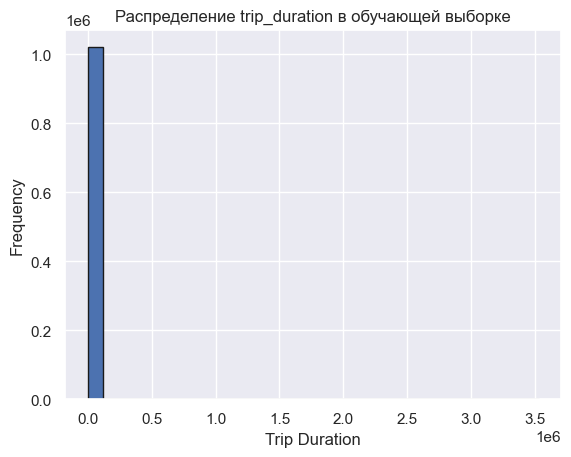

In [9]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(y_train, bins=30, edgecolor='k')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Распределение trip_duration в обучающей выборке')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: По гистограмме значений целевой переменной можно определить её тип (непрерывная или дискретная), форму распределения (нормальное, скошенное, бимодальное), центральные тенденции (среднее, медиана, мода) и наличие выбросов или дисбаланса классов. Это помогает оценить, подходит ли переменная для моделирования напрямую или требует преобразований, таких как нормализация или обработка аномалий, для улучшения точности моделей.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: Важное отличие RMLSE от RMSE: RMSLE имеет значение относительной ошибки, а RMSE абсолютной. В RMLSE масштаб ошибки не будет так сильно влиять на результат. Например, если длительность поездки составляет больше 30 минут, то RMLSE не будет так реагировать на ошибку в 1 минуту и в 2 минуты (тут эти ошибки можно считать равными), по сравнению с RMSE, где такая ошибка будет штрафоваться намного сильнее.

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

$a(x_i) = \exp(\hat{a}(x_i)) - 1$ = \\"$\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, $\hat{y}_i = \log{(y_i + 1)}$"\\ = $\log{(\exp({a}(x_i)) - 1 + 1)} = {a}(x_i)$

Аналогично для $\hat{a}(x_i)$:

$\hat{a}(x_i) = \exp({a}(x_i)) - 1 = \log{(\exp(\hat{a}(x_i)) - 1 + 1)} = \hat{a}(x_i)$

Свли задачу оптимизации RMSLE к задаче оптимизации MSE.

У логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

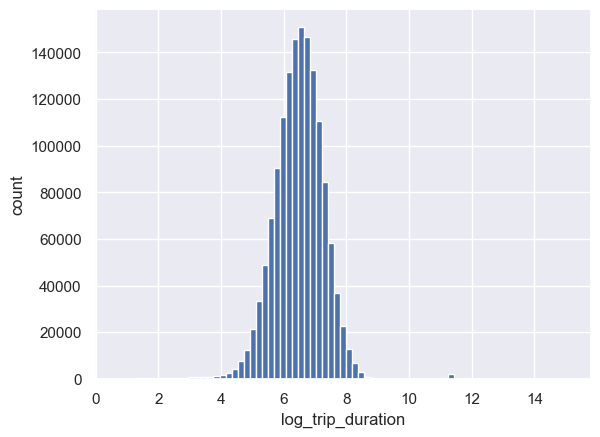

In [10]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data['log_trip_duration'] = np.log1p(data['trip_duration'].values)
plt.hist(data['log_trip_duration'], bins=75)
plt.xlabel('log_trip_duration')
plt.ylabel('count')
plt.show()

In [11]:
# удаляем колонку со старым таргетом так:
data.drop(columns=['trip_duration'])

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642
...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256


## Часть 1. Изучаем `pickup_datetime`

**Задание 2.**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

Text(0.5, 1.0, 'Зависимость количества поездок от дня в году')

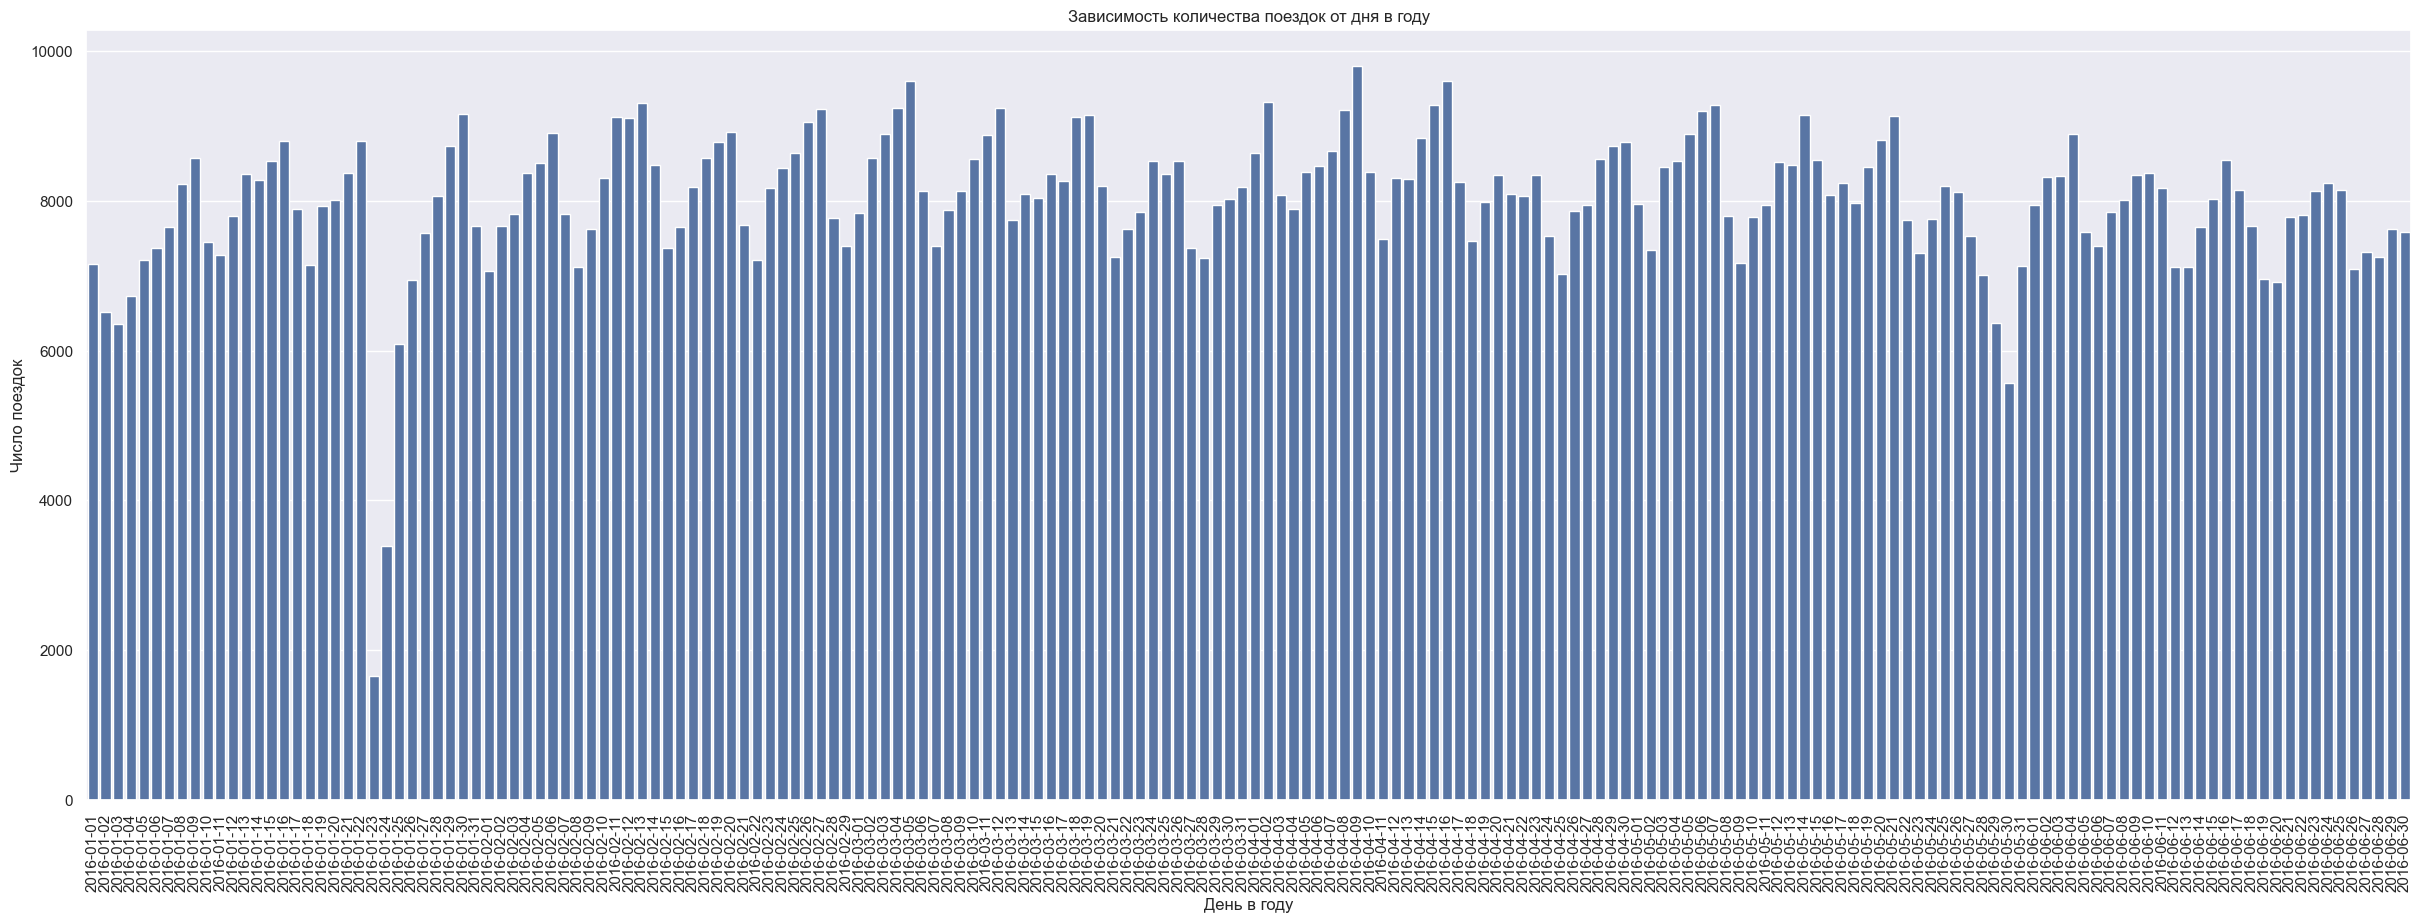

In [12]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(30, 10))

x = data['pickup_datetime'].dt.date
count_data = x.value_counts().sort_index()
sns.barplot(x=count_data.index, y=count_data.values)

plt.xlabel('День в году')
plt.ylabel('Число поездок')
plt.xticks(rotation=90)
plt.title('Зависимость количества поездок от дня в году')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [13]:
data['pickup_datetime'].dt.date.value_counts()[-2:]

pickup_datetime
2016-01-24    3383
2016-01-23    1648
Name: count, dtype: int64

Причина: [власти запретили автомобильное движение в Нью-Йорке из-за снежной бури](https://ria.ru/20160123/1364032228.html).

Первый период (23-24 января 2016 года) связан с запретом
автомобильного движения в Нью-Йорке из-за снежной бури
Второй период (30 мая 2016 года) -  День Поминовения ( Memorial Day) — национальный день памяти США,
отмечающийся ежегодно в последний понедельник мая.


Text(0.5, 1.0, 'Зависимость количества поездок от часа в сутках')

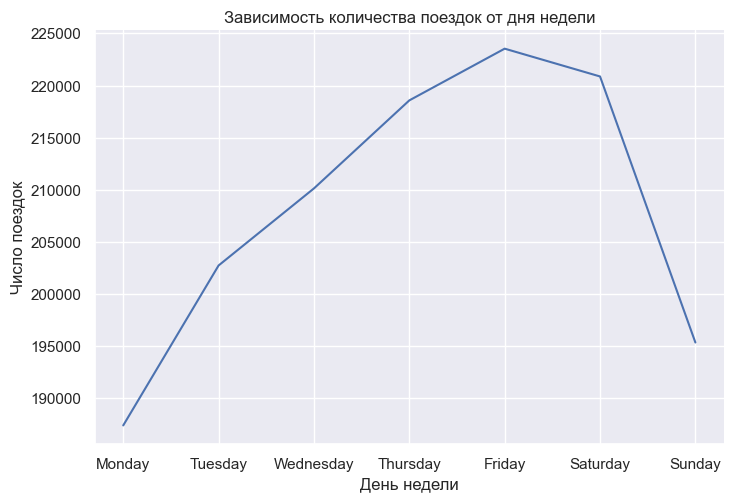

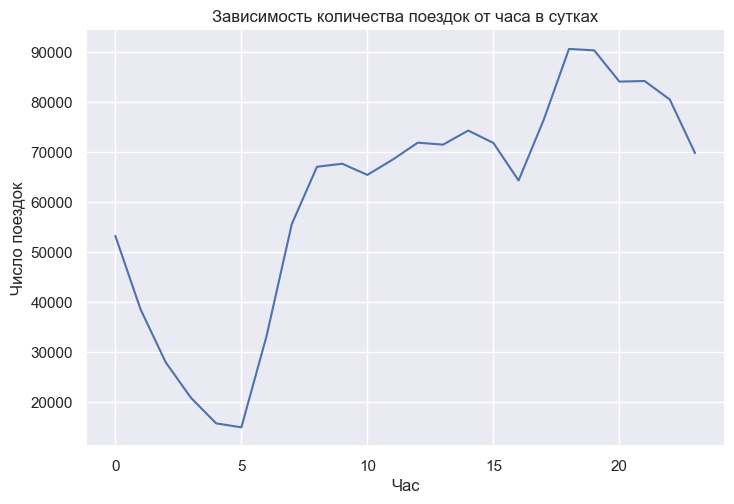

In [14]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data['pickup_datetime'].dt.date.value_counts()[-3:]
print("Первый период (23-24 января 2016 года) связан с запретом\n\
автомобильного движения в Нью-Йорке из-за снежной бури")
print("Второй период (30 мая 2016 года) -  День Поминовения ( Memorial Day) — национальный день памяти США,\n\
отмечающийся ежегодно в последний понедельник мая.")

x = data['pickup_datetime'].dt.day_name().value_counts().index
y = data['pickup_datetime'].dt.day_name().value_counts()

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = y.reindex(week_order).reset_index()
y.columns = ['День недели', 'Число поездок']

sns.relplot(data=y, x='День недели', y='Число поездок', aspect=1.5, kind='line')
plt.xlabel('День недели')
plt.ylabel('Число поездок')
plt.title('Зависимость количества поездок от дня недели')

x = data['pickup_datetime'].dt.hour.value_counts().index
y = data['pickup_datetime'].dt.hour.value_counts()
sns.relplot(x = x, y = y, aspect=1.5, kind='line')

plt.xlabel('Час')
plt.ylabel('Число поездок')
plt.title('Зависимость количества поездок от часа в сутках')

**Задание 3.**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

Text(0.5, 1.0, 'Зависимость количества поездок от часов в сутках (по дням недели)')

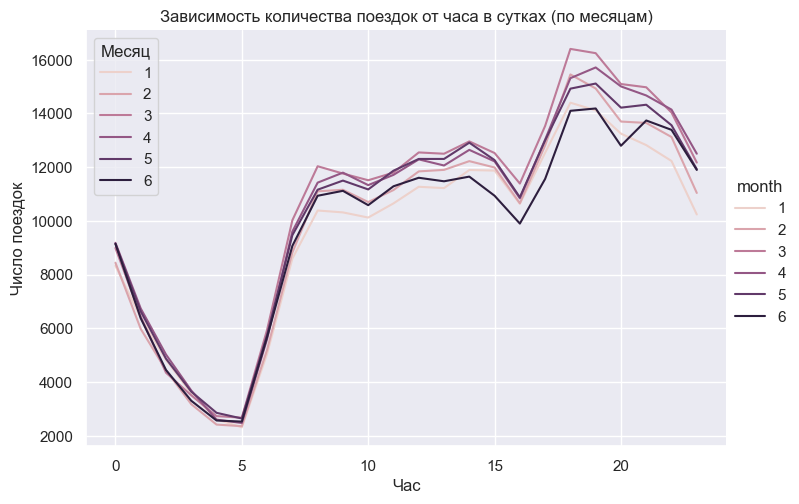

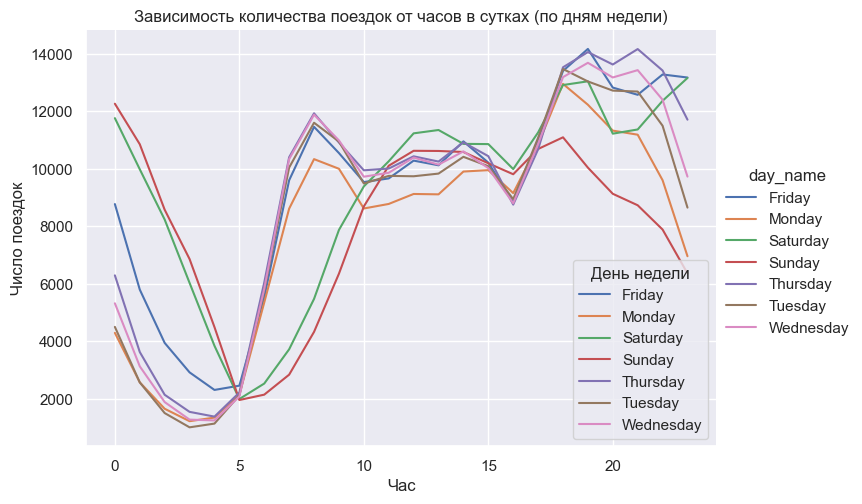

In [15]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data['hour'] = data['pickup_datetime'].dt.hour
data['month'] = data['pickup_datetime'].dt.month
data['day_name'] = data['pickup_datetime'].dt.day_name()
data['day_of_year'] = data['pickup_datetime'].dt.date
tmp = pd.DataFrame(data[['month','hour', 'day_name']])
sns.relplot(hue = 'month', x = 'hour', y = 'day_name', data = tmp.groupby(['month', 'hour']).count(), kind = 'line', aspect=1.5)

plt.xlabel('Час')
plt.ylabel('Число поездок')
plt.legend(title='Месяц')
plt.title('Зависимость количества поездок от часа в сутках (по месяцам)')


sns.relplot(hue = 'day_name', x = 'hour', y = 'month', data = tmp.groupby(['day_name', 'hour']).count(), kind = 'line', aspect=1.5)

plt.xlabel('Час')
plt.ylabel('Число поездок')
plt.legend(title='День недели')
plt.title('Зависимость количества поездок от часов в сутках (по дням недели)')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:** Месяца почти не отличаются, дни недели имеют небольшие отличия: по субботам и воскресеньям люди просыпаются позже; в будние дни возрастает количество поездок после 5 утра и после 4 дня.

**Задание 4.**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

Text(0.5, 1.0, 'Зависимость среднего логарифма времени поездки от дня в году')

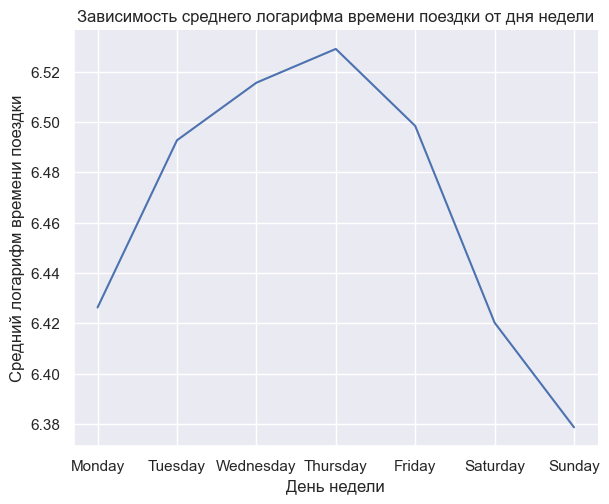

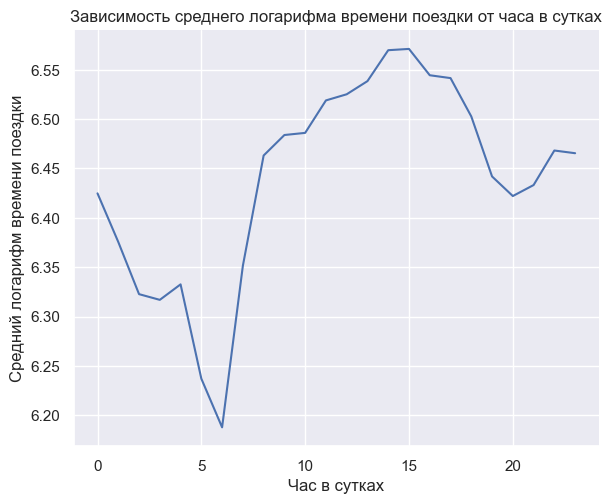

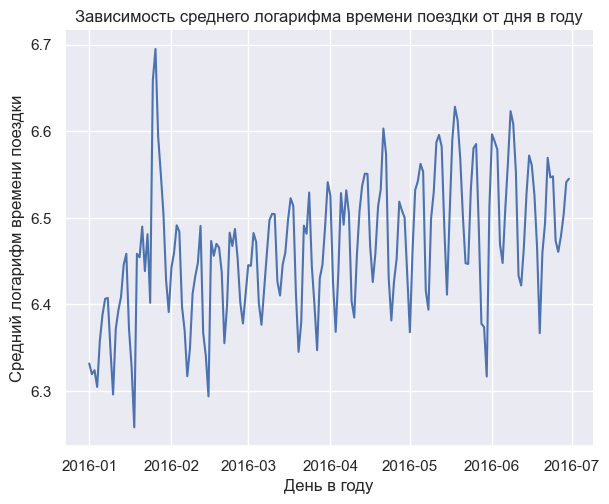

In [16]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train, test = train_test_split(data, train_size=0.7, test_size=0.3, random_state=123)
train['day_name'] = pd.Categorical(train['day_name'], categories=week_order, ordered=True)
x = train.groupby('day_name', observed=True)['log_trip_duration'].mean().index
y = train.groupby('day_name', observed=True)['log_trip_duration'].mean()

sns.relplot(x = x, y = y, kind='line', aspect=1.25)

plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени поездки')
plt.title('Зависимость среднего логарифма времени поездки от дня недели')


x = train.groupby('hour', observed=True)['log_trip_duration'].mean().index
y = train.groupby('hour', observed=True)['log_trip_duration'].mean()

sns.relplot(x = x, y = y, kind='line', aspect=1.25)

plt.xlabel('Час в сутках')
plt.ylabel('Средний логарифм времени поездки')
plt.title('Зависимость среднего логарифма времени поездки от часа в сутках')


x = train.groupby('day_of_year', observed=True)['log_trip_duration'].mean().index
y = train.groupby('day_of_year', observed=True)['log_trip_duration'].mean()

sns.relplot(x = x, y = y, kind='line', aspect=1.25)

plt.xlabel('День в году')
plt.ylabel('Средний логарифм времени поездки')
plt.title('Зависимость среднего логарифма времени поездки от дня в году')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:** График зависимости целевой переменной от времени суток напоминает грвфик количества поездок: ночью их меньше, а длительность короче из-за отсутствия пробок и преимущественно коротких маршрутов, в то время как днем активность растет (люди начинают день), возникают заторы, что удлиняет поездки, и чаще заказывают дальние расстояния.

А с зависимостью от дня недели сложно выявить закономерность.

На графиках по дням года заметны два аномальных пика среднего таргета, вероятно, вызванные внешними факторами вроде снежной бури в те периоды — в такую погоду движение замедляется, что повышает среднюю продолжительность поездок.

Тренд на графике зависимости `log_trip_duration` от номера дня в году вроде как восходящий.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [17]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
"""
day_name[1], month[2], hour[3] уже были добавлены:
data['hour'] = data['pickup_datetime'].dt.hour
data['month'] = data['pickup_datetime'].dt.month
data['day_name'] = data['pickup_datetime'].dt.day_name()
"""

train['is_anomaly'] = 0
train.loc[train['pickup_datetime'].dt.date.isin(train['pickup_datetime'].dt.date.value_counts()[-2:].index),'is_anomaly'] = 1
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear

test['is_anomaly'] = 0
test.loc[test['pickup_datetime'].dt.date.isin(test['pickup_datetime'].dt.date.value_counts()[-2:].index),'is_anomaly'] = 1
test['day_of_year'] = test['pickup_datetime'].dt.dayofyear

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ:** Номер дня в году можно счиать численным признаком. Месяц скорее категориальный (нельзя сказать, что апрель больше января). День недели тоже категориальный. Час лучше рассматривать как категориальный признак, потому что то, что час больше, не гарантирует, что поездка будет дольше.

**Задание 5.**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [18]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np

X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'is_anomaly']  
num_feats = ['day_of_year'] 

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct), 
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.7856
Test MSE = 0.6172
Train RMSE = 0.7903
Train MSE = 0.6246


## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Подготовлена функция, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [19]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [20]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [77]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[np.float64(40.75120984268189), np.float64(-73.97328739929199)], controls=(ZoomControl(options=['po…

In [78]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Map(center=[np.float64(40.753255794525145), np.float64(-73.97357878875732)], controls=(ZoomControl(options=['p…

**Вопрос**: Какие две точки выделяются на карте?

**Ответ:** Явно выделяются аэропорты La Guardia и John F Kennedy.

**Задание 6.**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [23]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [24]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['log_haversine'] = np.log1p(haversine(train.pickup_longitude, train.pickup_latitude, train.dropoff_longitude, train.dropoff_latitude))
train['haversine'] = haversine(train.pickup_longitude, train.pickup_latitude, train.dropoff_longitude, train.dropoff_latitude)
test['log_haversine'] = np.log1p(haversine(test.pickup_longitude, test.pickup_latitude, test.dropoff_longitude, test.dropoff_latitude))
test['haversine'] = haversine(test.pickup_longitude, test.pickup_latitude, test.dropoff_longitude, test.dropoff_latitude)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [25]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[:,['log_haversine','log_trip_duration','haversine']].corr().iloc[[0,2],[1]]

,log_trip_duration
log_haversine,0.675758
haversine,0.531519


**Задание 7.** Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

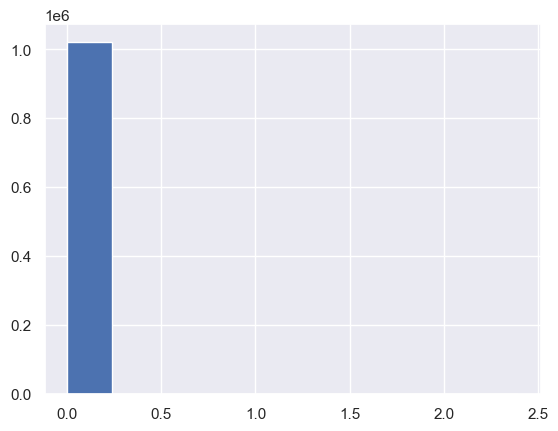

In [26]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['velocity'] = (train['haversine']) / (train['trip_duration'])
test['velocity'] = (test['haversine']) / (test['trip_duration'])
plt.hist(train['velocity']);

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

(array([ 45889., 156437., 169533., 161199., 139118., 106673.,  73446.,
         48840.,  32448.,  22442.]),
 array([0.        , 0.00069083, 0.00138166, 0.00207249, 0.00276331,
        0.00345414, 0.00414497, 0.0048358 , 0.00552663, 0.00621746,
        0.00690829]),
 <BarContainer object of 10 artists>)

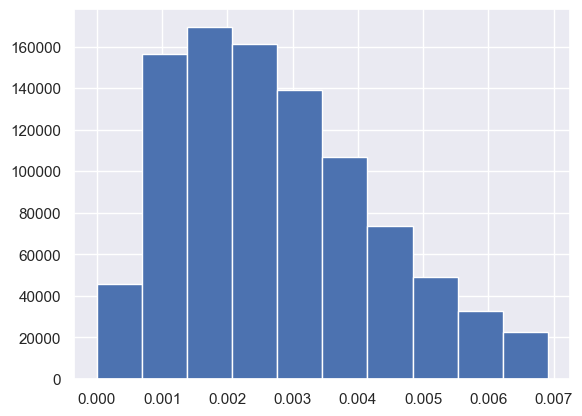

In [27]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
tmp = train[train['velocity'] < train['velocity'].mean() + train['velocity'].std()]
plt.hist(tmp['velocity'])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [28]:
tmp = []

tmp.append(train[train['day_name'] == 'Monday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Tuesday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Wednesday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Thursday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Friday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Saturday'].groupby(['hour']).median(numeric_only=True).velocity)
tmp.append(train[train['day_name'] == 'Sunday'].groupby(['hour']).median(numeric_only=True).velocity)

Text(467.25, 0.5, 'день недели')

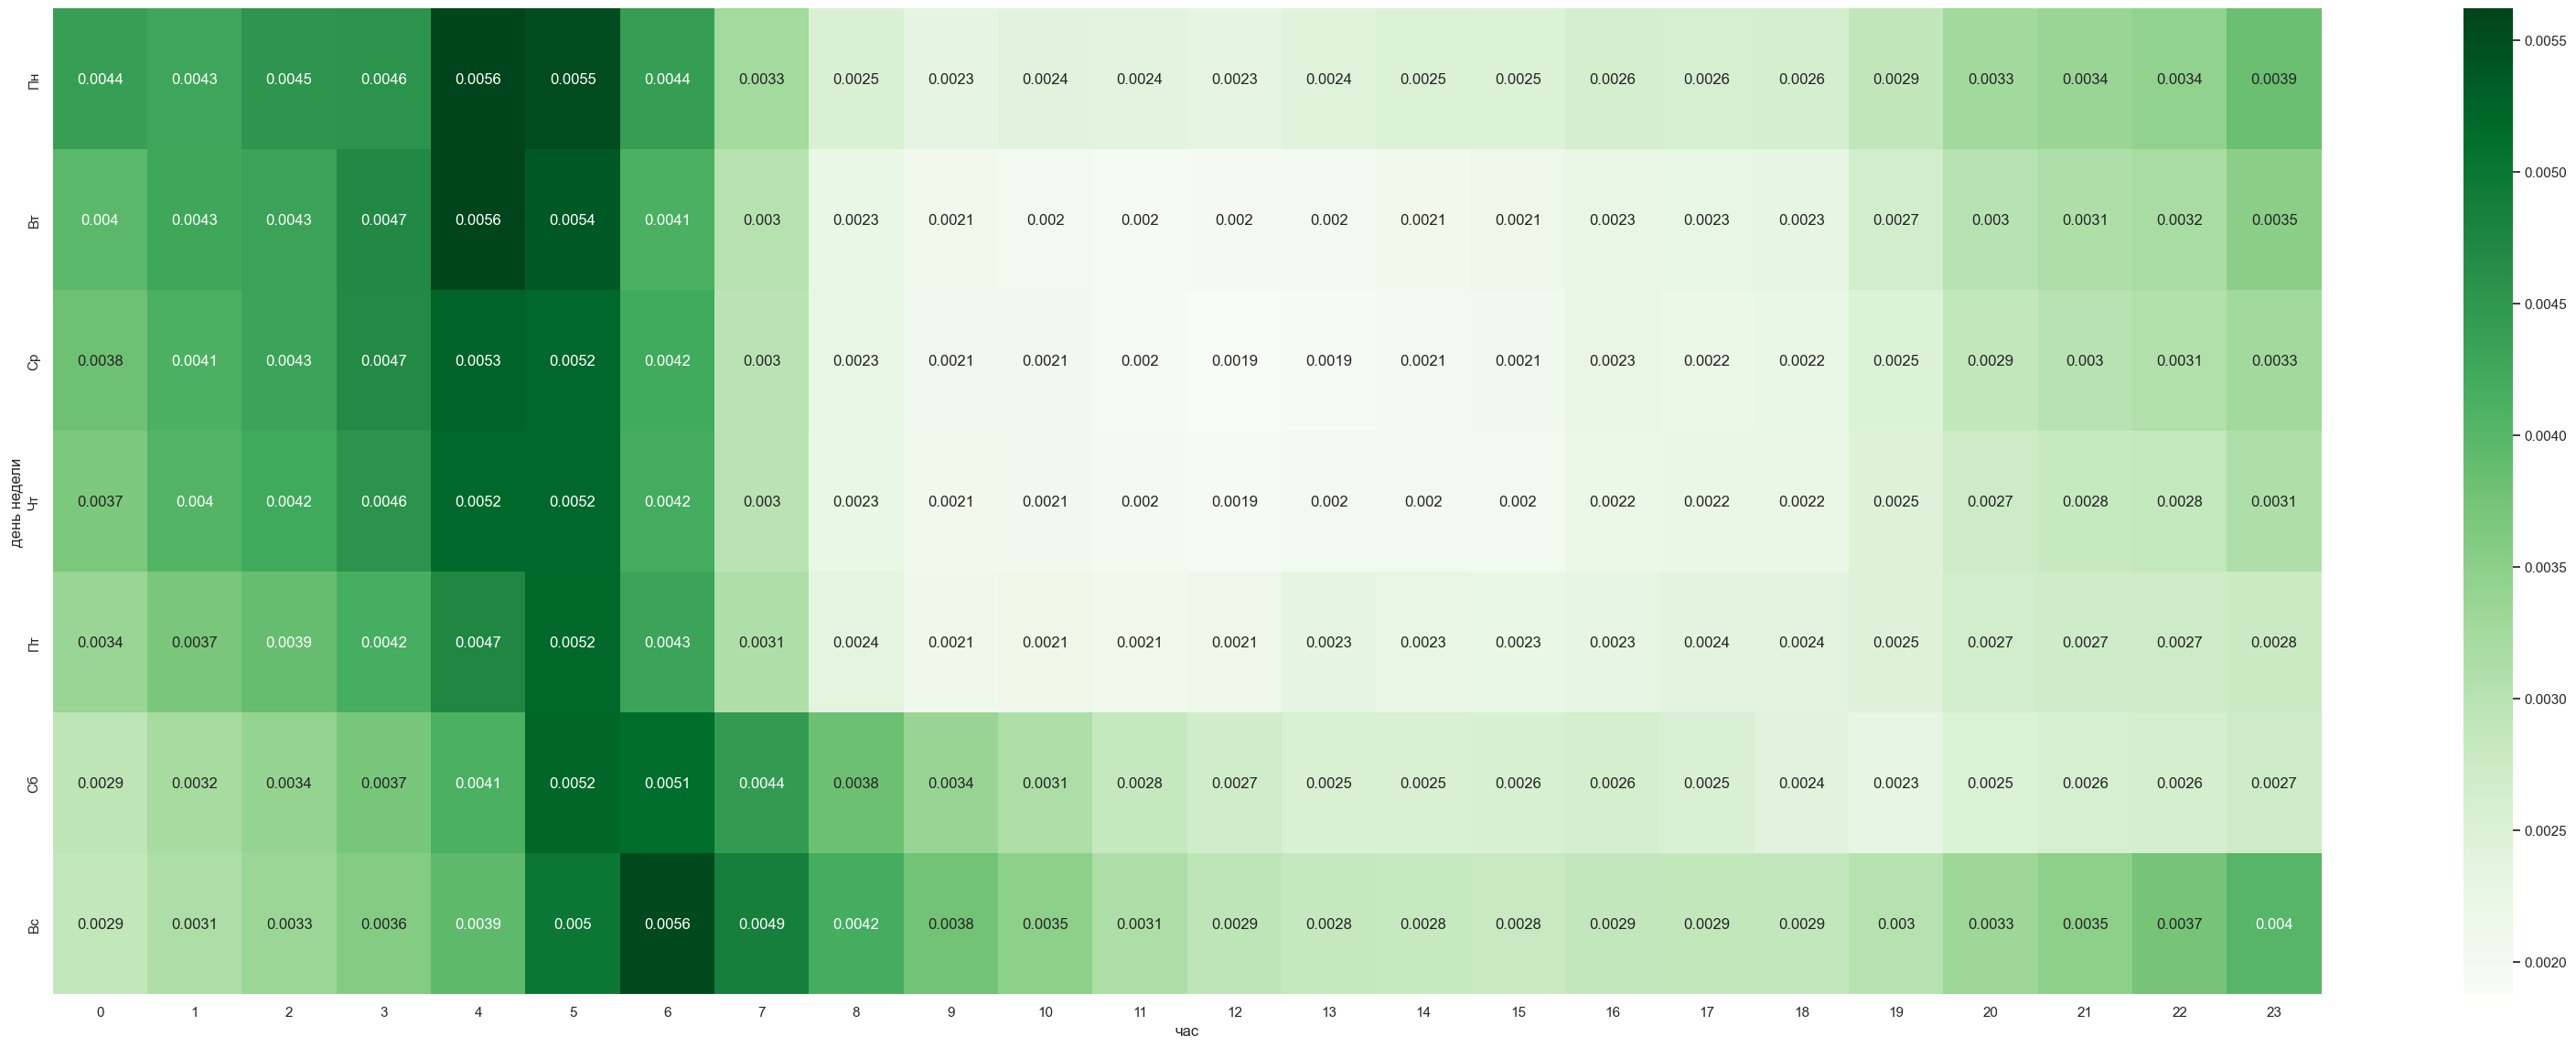

In [29]:
sns.set(rc={'figure.figsize':(40,14)})

plt.xticks(train['hour'].unique())
sns.heatmap(tmp, cmap='Greens', annot=True, yticklabels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

plt.xlabel("час")
plt.ylabel("день недели")

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** Через скорость мы сразу можем получить таргет, поэтому нет смысла в обучении модели, так как мы просто даем ей значение, которое надо найти. Мы также не можем для тестовой выборки понять скорость, так как у нас нет значения расстояния. Поэтому мы не можем использовать этот признак.

In [30]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.drop('velocity', inplace = True, axis=1)
test.drop('velocity', inplace = True, axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

**Ответ:** Скорость минимальна: 1) сб: с 13 до 22; 2) будние: с 8 до 19. (самые светлые на графике)

В остальное время скорость максимальна.

In [31]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['is_slow'] = 0
train.loc[(train['hour'] > 13) & (train['hour'] < 22) & (train['day_name'] != 'Saturday'), 'is_slow'] = 1
train.loc[((train['hour'] > 8) & (train['hour'] < 19) & (train['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))), 'is_slow'] = 1

test['is_slow'] = 0
test.loc[(test['hour'] > 13) & (test['hour'] < 22) & (test['day_name'] != 'Saturday'), 'is_slow'] = 1
test.loc[((test['hour'] > 8) & (test['hour'] < 19) & (test['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))), 'is_slow'] = 1

**Задание 8.** Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорте.

In [32]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['airport_start'] = 0
train['airport_finish'] = 0

test['airport_start'] = 0
test['airport_finish'] = 0

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [33]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.rcParams['figure.figsize'] = 10, 8
sns.boxplot(data=train, x='airport_start', y='log_trip_duration', hue='airport_start', palette="Set3", legend=False)

<Axes: xlabel='airport_start', ylabel='log_trip_duration'>

<Axes: xlabel='airport_finish', ylabel='log_trip_duration'>

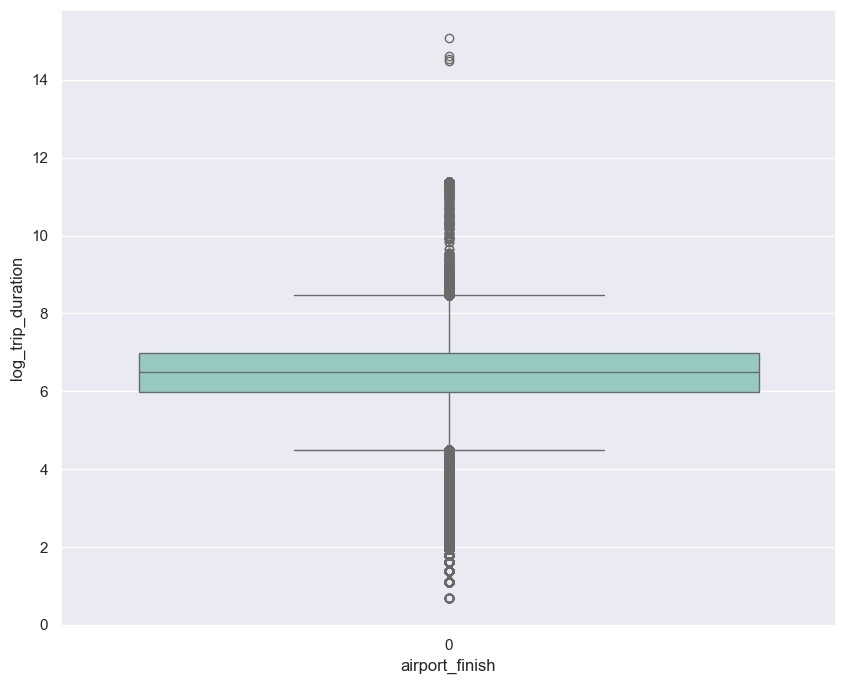

In [34]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.rcParams['figure.figsize'] = 10, 8
sns.boxplot(data=train, x='airport_finish', y='log_trip_duration', hue='airport_finish', palette="Set3", legend=False)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ:** Длительность поездок, которые начинаются или заканчиваются в аэропортах, больше, чем у других. Это логично, поэтому будем считать признаки хорошими.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9.** Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [68]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Границы сетки (на основе рисунка): 4 ряда широты, 3 столбца долготы
        self.bins_lat = [40.70, 40.73, 40.76, 40.79, 40.82]  # 4 интервала
        self.bins_lon = [-74.02, -73.99, -73.96, -73.93]     # 3 интервала
        self.labels_lat = [0, 1, 2, 3]  # Индексы рядов (0-3)
        self.labels_lon = [0, 1, 2]     # Индексы столбцов (0-2)
    
    def show_map(self, X=None):
        import folium  # Импорт здесь, чтобы избежать глобальных зависимостей
        if X is None:
            X = train  # Используем train по умолчанию, если X не передан
        
        # Создаём карту с центром на среднем значении pickup
        center_lat = X['pickup_latitude'].mean()
        center_lon = X['pickup_longitude'].mean()
        map_obj = folium.Map(location=[center_lat, center_lon], zoom_start=12)
        
        # Добавляем круги для pickup-точек (синие, как в show_circles_on_map)
        sample = X.sample(min(1000, len(X)))  # Ограничиваем 1000 точек
        for _, row in sample.iterrows():
            folium.CircleMarker(
                location=[row['pickup_latitude'], row['pickup_longitude']],
                radius=3,  # Маленький радиус для точек
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6
            ).add_to(map_obj)
        
        # Линии сетки
        lines = [
            [(40.82, -74.02), (40.82, -73.93)],
            [(40.79, -74.02), (40.79, -73.93)],
            [(40.76, -74.02), (40.76, -73.93)],
            [(40.73, -74.02), (40.73, -73.93)],
            [(40.70, -74.02), (40.70, -73.93)],
            [(40.82, -74.02), (40.70, -74.02)],
            [(40.82, -73.99), (40.70, -73.99)],
            [(40.82, -73.96), (40.70, -73.96)],
            [(40.82, -73.93), (40.70, -73.93)],
        ]
        for line in lines:
            folium.PolyLine(line, color='red', weight=5).add_to(map_obj)
        
        return map_obj
      
    def fit(self, X=None, y=None):
        # Границы фиксированы, fit не нужен для вычислений
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()  # Копируем, чтобы не модифицировать оригинал inplace
        
        # Векторизованное присвоение для pickup
        lat_idx_pickup = pd.cut(X_transformed['pickup_latitude'], bins=self.bins_lat, labels=self.labels_lat, right=False)
        lon_idx_pickup = pd.cut(X_transformed['pickup_longitude'], bins=self.bins_lon, labels=self.labels_lon, right=False)
        # Номер ячейки: (ряд * 3) + столбец + 1 (если оба индекса не NaN, иначе -1)
        X_transformed['grid_pickup'] = np.where(
            lat_idx_pickup.notna() & lon_idx_pickup.notna(),
            lat_idx_pickup.cat.codes * 3 + lon_idx_pickup.cat.codes + 1,
            -1
        )
        
        # Аналогично для dropoff
        lat_idx_dropoff = pd.cut(X_transformed['dropoff_latitude'], bins=self.bins_lat, labels=self.labels_lat, right=False)
        lon_idx_dropoff = pd.cut(X_transformed['dropoff_longitude'], bins=self.bins_lon, labels=self.labels_lon, right=False)
        X_transformed['grid_dropoff'] = np.where(
            lat_idx_dropoff.notna() & lon_idx_dropoff.notna(),
            lat_idx_dropoff.cat.codes * 3 + lon_idx_dropoff.cat.codes + 1,
            -1
        )
        
        return X_transformed

In [36]:
grid1 = MapGridTransformer()
grid1.fit(train)  # fit пустой, но обязателен для sklearn
add_train = grid1.transform(train)

grid2 = MapGridTransformer()
grid2.fit(test)
add_test = grid2.transform(test)

In [37]:
grid1.show_map()

**Задание 10.** Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [38]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
transformer = MapGridTransformer()
add_train = transformer.fit_transform(train)
add_test = transformer.transform(test)

train['grid_pickup'] = add_train['grid_pickup']
train['grid_dropoff'] = add_train['grid_dropoff']

test['grid_pickup'] = add_test['grid_pickup']
test['grid_dropoff'] = add_test['grid_dropoff']

X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine',  'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'airport_start', 'airport_finish', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))


Test RMSE = 0.5515
Test MSE = 0.3041
Train RMSE = 0.5550
Train MSE = 0.3080


## Часть 3. Изучаем оставшиеся признаки

**Задание 11.** У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [39]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('count of unique values:')
print('vendor_id:', train['vendor_id'].unique().shape[0])
print('passenger_count:', train['passenger_count'].unique().shape[0])
print('store_and_fwd_flag:', train['store_and_fwd_flag'].unique().shape[0])

count of unique values:
vendor_id: 2
passenger_count: 9
store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<Axes: xlabel='vendor_id', ylabel='log_trip_duration'>

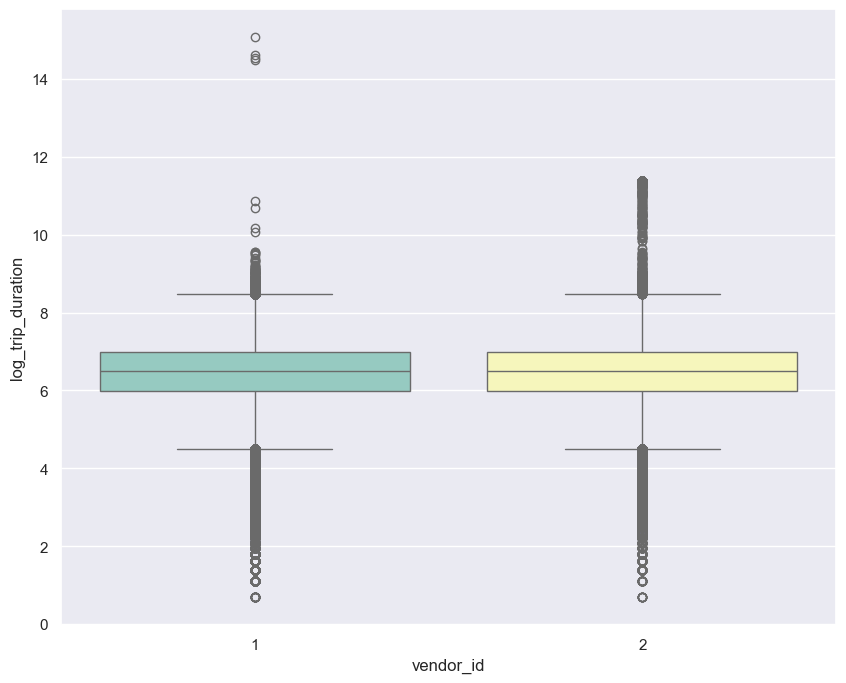

In [40]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(y=train['log_trip_duration'], x=train['vendor_id'], hue=train['vendor_id'], palette="Set3", data=train, legend=False)

<Axes: xlabel='passenger_count', ylabel='log_trip_duration'>

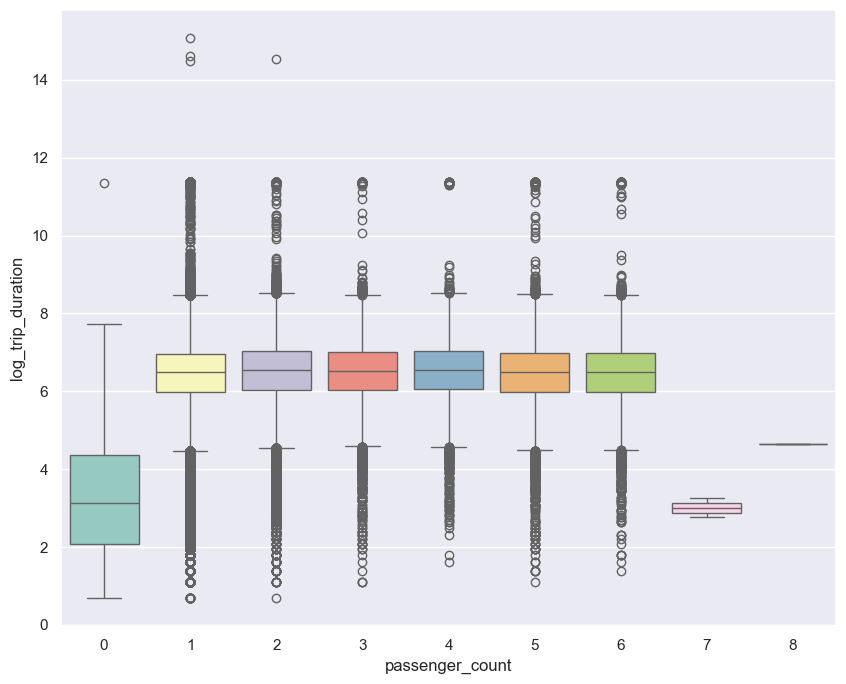

In [41]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(y=train['log_trip_duration'], x=train['passenger_count'], hue=train['passenger_count'], palette="Set3", data=train, legend=False)

<Axes: xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

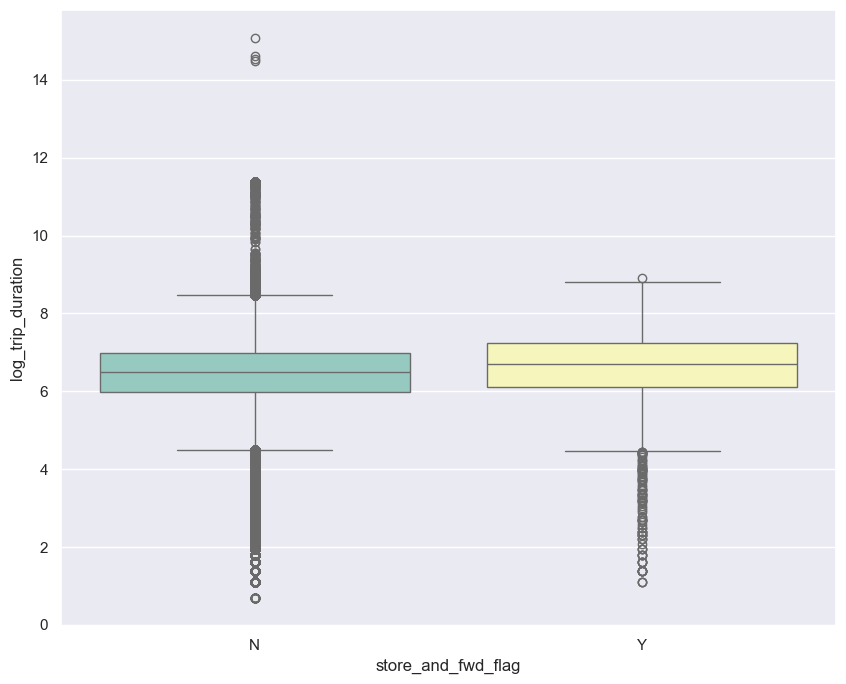

In [42]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(y=train['log_trip_duration'], x=train['store_and_fwd_flag'], hue=train['store_and_fwd_flag'], palette="Set3", data=train, legend=False)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [43]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd

train['vendor_id'] = train['vendor_id'].replace({1: 0, 2: 1}).astype(int)
test['vendor_id'] = test['vendor_id'].replace({1: 0, 2: 1}).astype(int)

train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1}).astype(int)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({'N': 0, 'Y': 1}).astype(int)

C:\Temp\ipykernel_14948\319423720.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1}).astype(int)
C:\Temp\ipykernel_14948\319423720.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({'N': 0, 'Y': 1}).astype(int)


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ:** Признаки не сильно помогут, потому что для разных значений признака мы получаем практически одинаковые значения целевой переменной. Исключение — passenger_count: когда он равен 0, длительность обычно короче, потому что это, скорее всего, случаи, когда такси едет за заказчиком, и выбирается ближайшая машина. Если же passenger_count не равен 0, продолжительность выше. Также при store_and_fwd_flag == 'Y' длительность слегка увеличивается, но это не слишком заметно.

**Задание 12.** Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [44]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'airport_start', 'airport_finish', 'grid_pickup', 'vendor_id', 'grid_dropoff', 'store_and_fwd_flag']
num_feats = ['day_of_year', 'passenger_count', 'is_anomaly', 'is_slow', 'log_haversine']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5513
Test MSE = 0.3039
Train RMSE = 0.5548
Train MSE = 0.3078


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель

**Задание 13.** В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

In [45]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'airport_start', 'airport_finish', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5515
Test MSE = 0.3041
Train RMSE = 0.5550
Train MSE = 0.3080


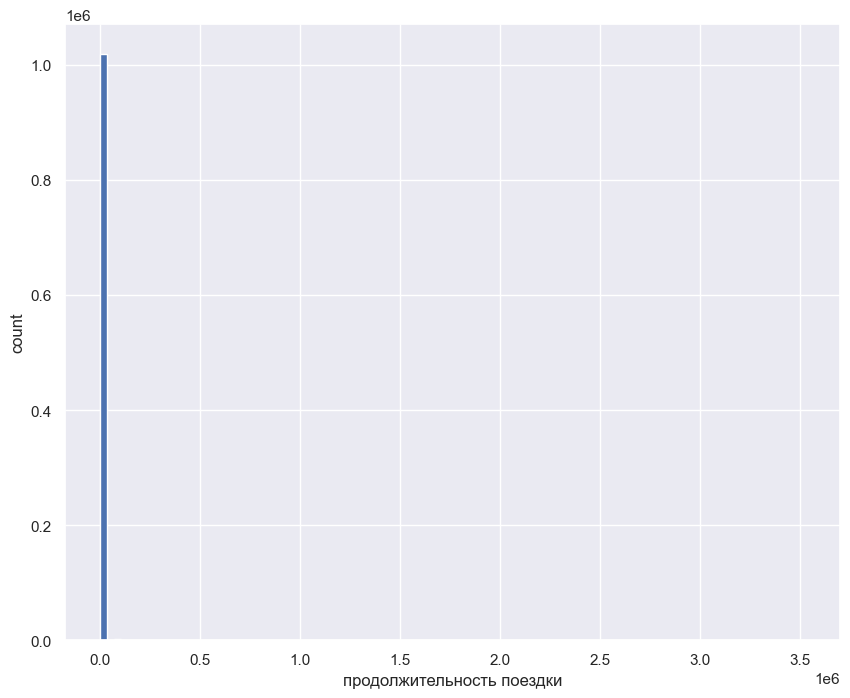

In [46]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train['trip_duration'], bins=100)
plt.xlabel('продолжительность поездки')
plt.ylabel('count')
plt.show()

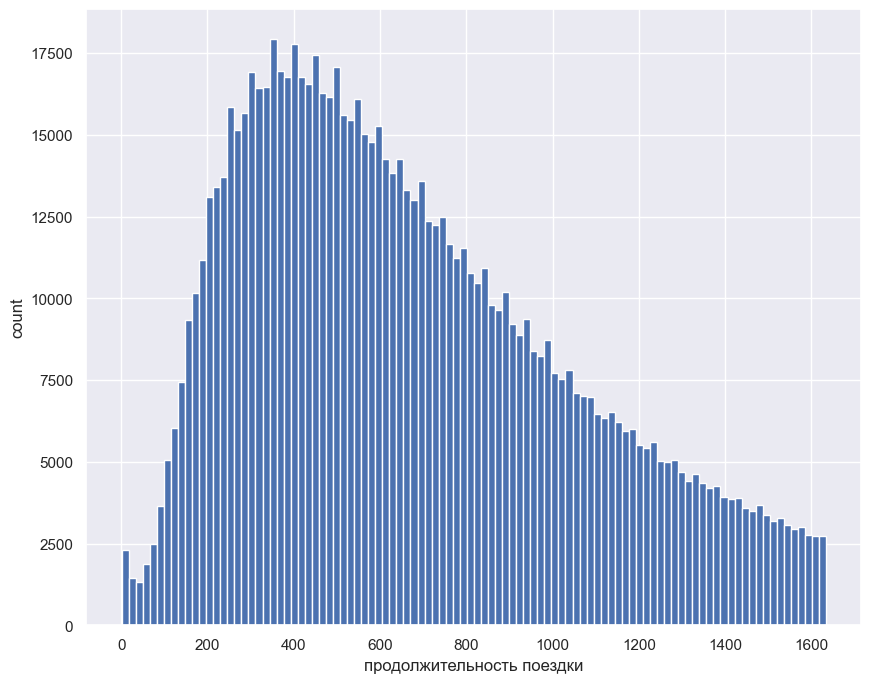

In [47]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train = train[(train['trip_duration'] < train['trip_duration'].quantile(0.90))]

plt.hist(train['trip_duration'], bins=100)
plt.xlabel('продолжительность поездки')
plt.ylabel('count')
plt.show()

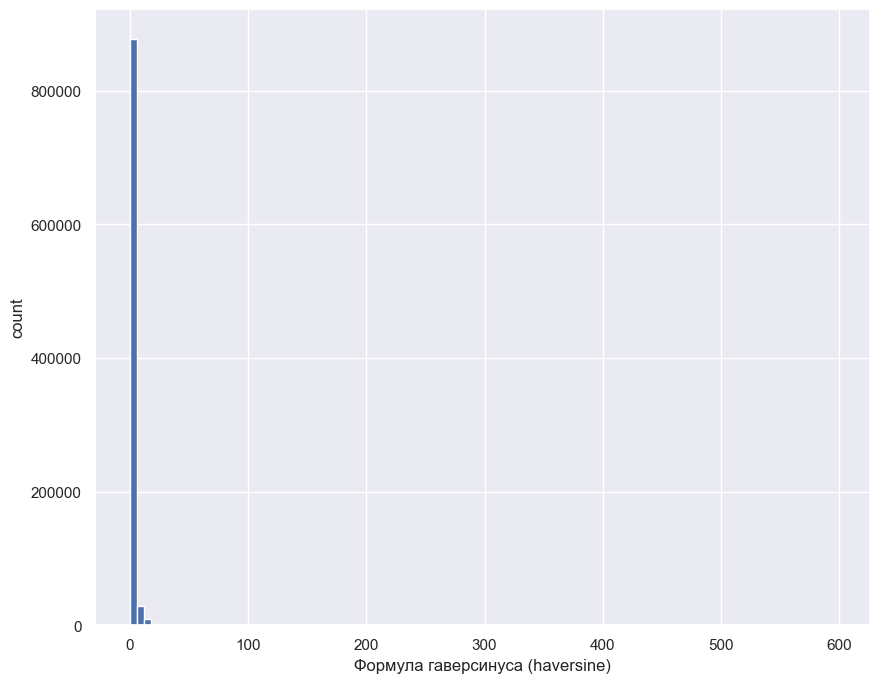

In [48]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train['haversine'], bins=100)
plt.xlabel('Формула гаверсинуса (haversine)')
plt.ylabel('count')
plt.show()

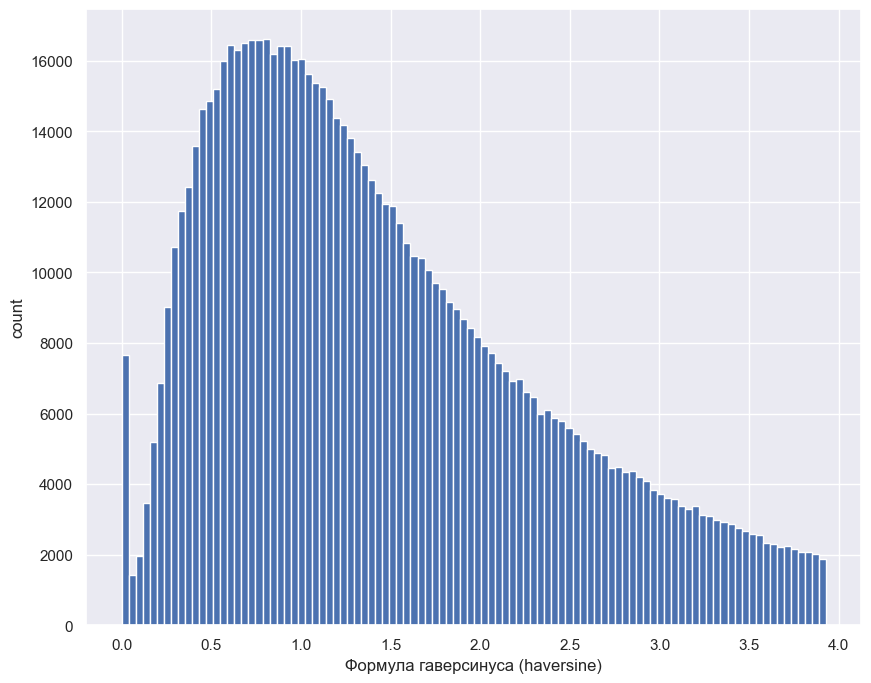

In [49]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train = train[(train['haversine'] < train['haversine'].quantile(0.90))]

plt.hist(train['haversine'], bins=100)
plt.xlabel('Формула гаверсинуса (haversine)')
plt.ylabel('count')
plt.show()

In [74]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport_start', 'airport_finish', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'airport_start', 'airport_finish', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5745
Test MSE = 0.3301
Train RMSE = 0.5168
Train MSE = 0.2670


C:\Temp\ipykernel_14948\2979029767.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


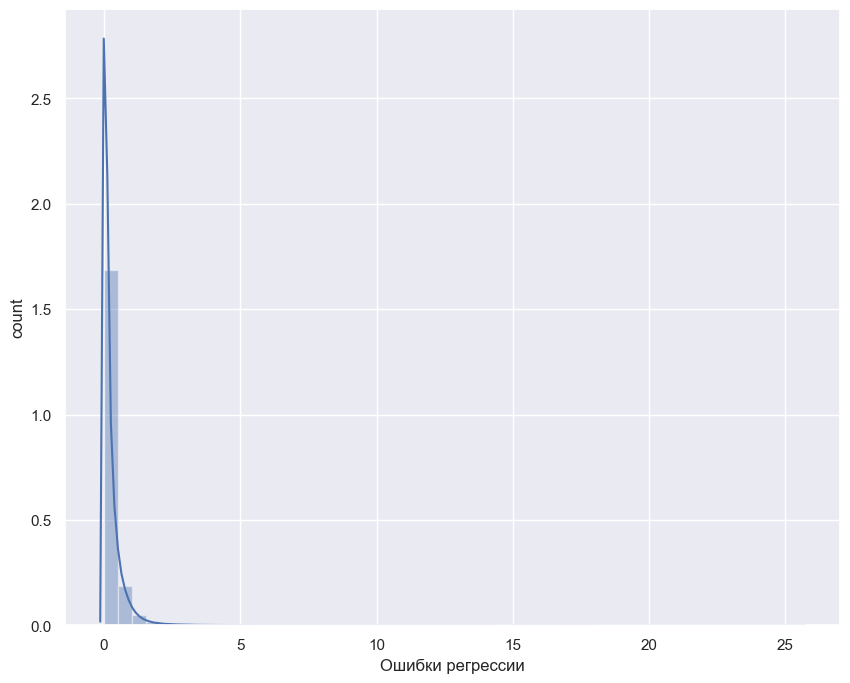

In [75]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)
plt.xlabel('Ошибки регрессии')
plt.ylabel('count')
plt.show()

In [52]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mask = ((error < np.quantile(error, 0.90)))

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pl.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5685
Test MSE = 0.3232
Train RMSE = 0.5179
Train MSE = 0.2682


C:\Temp\ipykernel_14948\2392250619.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


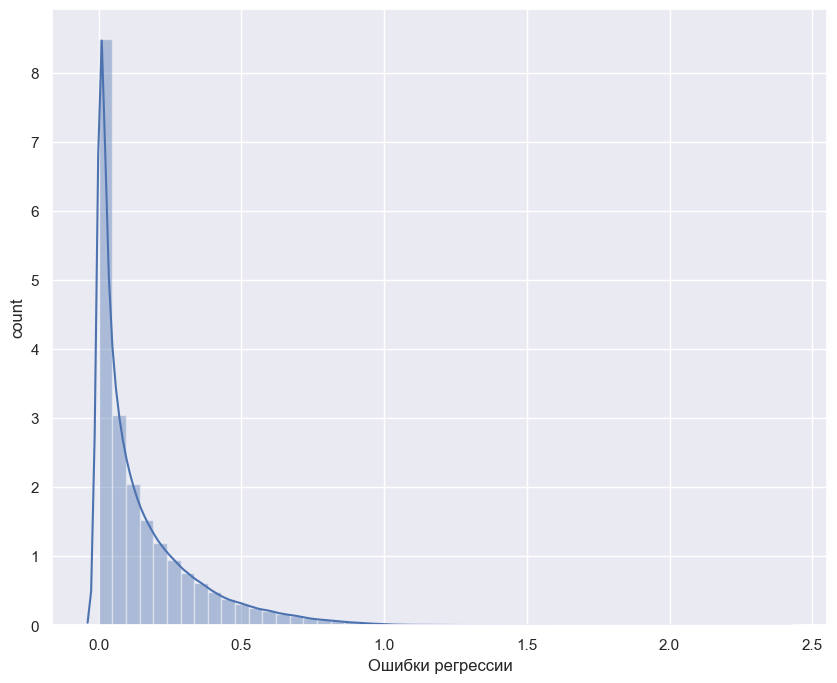

In [76]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error)
plt.xlabel('Ошибки регрессии')
plt.ylabel('count')
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [54]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
notnum_feats
['hour',
 'day_of_week',
 'month',
 'airport_start',
 'airport_finish',
 'grid_first',
 'grid_second']

train.loc[train['airport_start'] == 2, 'airport_start'] = 1
test.loc[test['airport_start'] == 2, 'airport_start'] = 1
train.loc[train['airport_finish'] == 2, 'airport_finish'] = 1
test.loc[test['airport_finish'] == 2, 'airport_finish'] = 1

notnum_feats = ['hour', 'day_name', 'month', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly', 'airport_start', 'airport_finish']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5747
Test MSE = 0.3303
Train RMSE = 0.5164
Train MSE = 0.2666


In [55]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
error = (y_train - model.predict(X_train)) ** 2
mask = (error < np.quantile(error, 0.90))

notnum_feats = ['hour', 'day_name', 'month', 'airport_start', 'airport_finish', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pl.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
X_train = X_train[mask]
y_train = y_train[mask]

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5685
Test MSE = 0.3232
Train RMSE = 0.3708
Train MSE = 0.1375


Попробуем объединить признаки с аэропортами следующим образом: если в маршруте одно из направлений аэропорт, то 1, иначе 0. И мы можем уже учитывать этот признак как численный.

In [56]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['airport'] = train['airport_start'] | train['airport_finish']
test['airport'] = test['airport_start'] | test['airport_finish']

X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name', 'month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'grid_pickup', 'grid_dropoff'] 
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly', 'airport'] 

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5747
Test MSE = 0.3303
Train RMSE = 0.5164
Train MSE = 0.2666


In [57]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
error = (y_train - model.predict(X_train)) ** 2
mask = (error < np.quantile(error, 0.90))

notnum_feats = ['hour', 'day_name', 'month', 'grid_pickup', 'grid_dropoff']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly', 'airport']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

X_train = X_train[mask]
y_train = y_train[mask]

Test RMSE = 0.5685
Test MSE = 0.3232
Train RMSE = 0.5179
Train MSE = 0.2682


До объединения признаков с аэропортами после кодирования было 6 (два признака по три возможных варианта), а после объединения их стало 2.

**Задание 14.** После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [58]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']
print("Размер до OneHot-кодирования:", X_train.shape)
print("Размер после OneHot-кодирования:", column_transformer.transform(X_train).shape)

Размер до OneHot-кодирования: (826928, 10)
Размер после OneHot-кодирования: (826928, 68)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [59]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.8227
Test MSE = 0.6769
Train RMSE = 0.6710
Train MSE = 0.4502


In [60]:
error = (y_train - model.predict(X_train)) ** 2
mask = (error < np.quantile(error, 0.90))

X_train = X_train[mask]
y_train = y_train[mask]

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

In [61]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train, val = train_test_split(train, test_size=0.2)

X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
X_val = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff']]
y_train = train['log_trip_duration']
y_val = test['log_trip_duration']

from sklearn.model_selection import GridSearchCV

pl = Pipeline(steps=[
     ('ohe_and_scaling', ct),
     ('regression', Ridge())
 ])

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pl, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", n_jobs=-1)
searcher.fit(X_val, y_val)

best_alpha1 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha1)

Best alpha = 14.3845


In [62]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge(best_alpha1))
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5745
Test MSE = 0.3301
Train RMSE = 0.5168
Train MSE = 0.2670


In [63]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV

lasso_pipeline = Pipeline(steps=[
      ('ohe_and_scaling', column_transformer),
      ('regression', Lasso())
  ])

alphas = np.logspace(-4, 3, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", n_jobs=-1)
searcher.fit(X_val, y_val)

best_alpha_lasso1 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha_lasso1)

Best alpha = 0.0001


In [64]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

lpl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Lasso(alpha=best_alpha_lasso1, max_iter=10000, tol=1e-4)) 
])

model = lpl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5742
Test MSE = 0.3297
Train RMSE = 0.5168
Train MSE = 0.2671


Lasso явно улучшилось, а Ridge почему-то совсем немного. Но в итоге метрики получились практически одинаковыми для Ridge и Lasso.

Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

C:\Temp\ipykernel_14948\3565669632.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  count_of_zs = pd.concat([count_of_zs, to_add], ignore_index=True)


Text(16.694444444444443, 0.5, 'count')

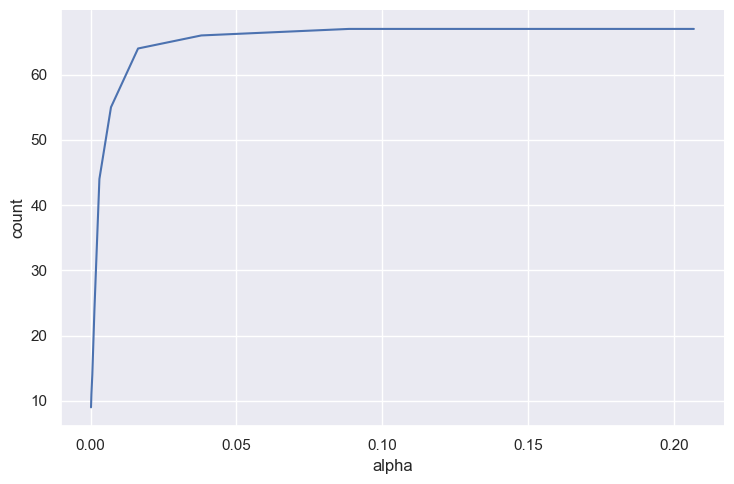

In [65]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
count_of_zs = pd.DataFrame(columns=['alpha', 'count'])

for alpha in np.logspace(-4, 3, 20):
    ct = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
        ('scaling', StandardScaler(), num_feats)
    ])

    lpl = Pipeline(steps=[
        ('ohe_and_scaling', ct),
        ('regression', Lasso(alpha=alpha, max_iter=10000, tol=1e-4)) 
    ])

    model = lpl.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    to_add = pd.DataFrame({'alpha': [alpha], 'count': [sum(model.named_steps['regression'].coef_ == 0)]})
    count_of_zs = pd.concat([count_of_zs, to_add], ignore_index=True)

x = count_of_zs['alpha'].head(10)
y = count_of_zs['count'].head(10)

sns.relplot(x = x, y = y, aspect=1.5, kind='line')

plt.xlabel('alpha')
plt.ylabel('count')

In [66]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

lpl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Lasso(alpha=best_alpha_lasso1, max_iter=10000, tol=1e-4))
])

model = lpl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.square(mean_squared_error(y_test, y_pred)))

0.10873130958144393


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15.** Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ:** Признак полезный, так как если таких поездок много в обучающих данных, то скорее всего это распространенные поездки, следовательно их будет много и в тестовых данных. Линейная модель не может это вытащить, так как это нелинейная зависимость грубо говоря. Получается, что то, откуда началась поездка и где закончилась, - это отдельные признаки, и наша модель их не комбинирует между, а маршрут (т. е. комбинация этих двух признаков) - это уже новый целый признак.

In [69]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import sklearn.preprocessing as pp
train['top100'] = '-1'
train['route'] = train['grid_pickup'].astype(str) + ', ' + train['grid_dropoff'].astype(str)

test['top100'] = '-1'
test['route'] = test['grid_pickup'].astype(str) + ', ' + test['grid_dropoff'].astype(str)

komb_grid = train[(train['route'] != 'nan, nan') & (train['route'] != '-1, -1')].groupby(['route']).count().sort_values('id').tail(100)

train.loc[train['route'].isin(komb_grid.index), 'top100'] = train['route']
test.loc[test['route'].isin(komb_grid.index), 'top100'] = test['route']

le = pp.LabelEncoder()
train['top100'] = le.fit_transform(train['top100'])
test['top100'] = le.transform(test['top100']) 

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [70]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train = train.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff', 'top100']]
X_test = test.drop(['log_trip_duration'], axis=1)[['hour', 'day_of_year', 'day_name','month', 'is_anomaly', 'log_haversine', 'airport', 'is_slow', 'grid_pickup', 'grid_dropoff', 'top100']]
y_train = train['log_trip_duration']
y_test = test['log_trip_duration']

notnum_feats = ['hour', 'day_name', 'month', 'grid_pickup', 'grid_dropoff', 'top100']
num_feats = ['day_of_year', 'log_haversine', 'is_slow', 'is_anomaly', 'airport']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5728
Test MSE = 0.3281
Train RMSE = 0.4892
Train MSE = 0.2393


In [71]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
error = (y_train - model.predict(X_train)) ** 2
mask = (error < np.quantile(error, 0.90))

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), notnum_feats),
    ('scaling', StandardScaler(), num_feats)
])

pl = Pipeline(steps=[
    ('ohe_and_scaling', ct),
    ('regression', Ridge())
])

model = pl.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

y_train_pred = model.predict(X_train)
print("Train RMSE = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5585
Test MSE = 0.3119
Train RMSE = 0.4907
Train MSE = 0.2408


In [73]:
train.drop('route', axis=1,inplace=True)
test.drop('route', axis=1,inplace=True)

KeyError: "['route'] not found in axis"